# COVID-19 Vaccine Coverage
### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import dataframe_image as dfi
import numpy as np
import matplotlib.pyplot as plt
import json
import os

from util import getLatestVaccineReport

#### Seaborn Plot Settings

In [2]:
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
sns.set(rc={'figure.figsize':(11.7,13.27)})

#### Pandas Advanced Settings

In [3]:
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#### Read the dataset
Get last vaccine report from GitHub and load the dataset

In [4]:
if getLatestVaccineReport() is True:
    fullDF = pd.read_csv("data/latest.csv")
    
fullDF    

[i] latest.csv downloaded in existing folder: data


,data_somministrazione,fornitore,area,fascia_anagrafica,sesso_maschile,sesso_femminile,prima_dose,seconda_dose,pregressa_infezione,dose_addizionale_booster,codice_NUTS1,codice_NUTS2,codice_regione_ISTAT,nome_area
0,2020-12-27,Moderna,SIC,90+,0,1,1,0,0,0,ITG,ITG1,19,Sicilia
1,2020-12-27,Pfizer/BioNTech,ABR,20-29,1,1,2,0,0,0,ITF,ITF1,13,Abruzzo
2,2020-12-27,Pfizer/BioNTech,ABR,30-39,1,4,5,0,0,0,ITF,ITF1,13,Abruzzo
3,2020-12-27,Pfizer/BioNTech,ABR,40-49,1,8,9,0,0,0,ITF,ITF1,13,Abruzzo
4,2020-12-27,Pfizer/BioNTech,ABR,50-59,7,6,13,0,0,0,ITF,ITF1,13,Abruzzo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179343,2022-01-26,Pfizer/BioNTech,VEN,60-69,544,641,116,77,2,990,ITH,ITH3,5,Veneto
179344,2022-01-26,Pfizer/BioNTech,VEN,70-79,293,438,52,49,1,629,ITH,ITH3,5,Veneto
179345,2022-01-26,Pfizer/BioNTech,VEN,80-89,122,207,18,21,0,290,ITH,ITH3,5,Veneto
179346,2022-01-26,Pfizer/BioNTech,VEN,90+,29,83,4,6,0,102,ITH,ITH3,5,Veneto


In the plot below, it is clear that most of the doses given are Pfizer, followed by Moderna, Vaxzevria and Janssen. Last vaccine (Pfizer Pediatrico) reguards kids between 5 and 12 years. 

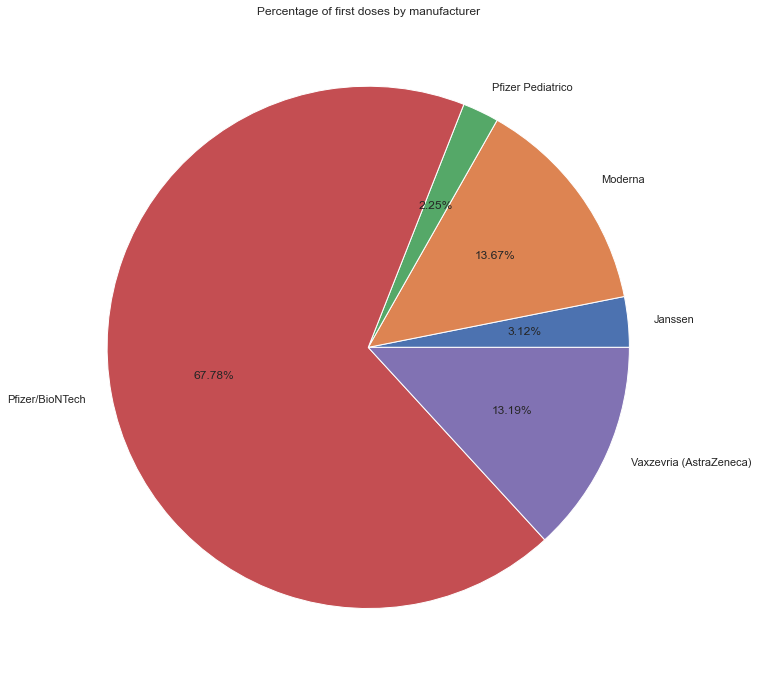

In [5]:
fullDF.groupby("fornitore")["prima_dose"].sum().plot.pie(autopct='%.2f%%',
                                                         ylabel='',
                                                         title='Percentage of first doses by manufacturer')
plt.savefig('1st_dose.png')

#### Dataset preprocessing
First of all we drop all the variable that cannot be used in our analysis. The area variable (also codice_NUTS1 and codice_NUTS2) are redundant and the gender is referred to all the doses administered in one day by a specific region so they cannot be used in this analysis; also pregressa_infezione, prima_dose and dose_addizionale_booster are useless here.

After this we need to select the row where we can find the vaccinated people. These rows are those who have a positive value of "seconda_dose", so we will filter the dataset by selecting those rows.

Here there is a misspecification because Trento and Bolzano are regions with special status and they are splitted in our dataset so since SVI (Social Vulnerable Index) is region-based we need to merge both Trento and Bolzano data into their region (Trentino Alto Adige).

Then just rename the rows containing one of them and put "Trentino Alto Adige".

In [6]:
vaccinati = fullDF.drop(['area', 'sesso_maschile','sesso_femminile','prima_dose','pregressa_infezione','dose_addizionale_booster','codice_NUTS1','codice_NUTS2'], axis=1)
vaccinati = vaccinati.loc[(vaccinati["seconda_dose"] > 0)].reset_index(drop=True)
vaccinati['nome_area'].loc[(vaccinati["nome_area"] == 'Provincia Autonoma Trento')] = 'Provincia Autonoma Bolzano / Bozen'
vaccinati.loc[(vaccinati["nome_area"] == 'Provincia Autonoma Bolzano / Bozen')]
vaccinati['nome_area'].loc[(vaccinati["nome_area"] == 'Provincia Autonoma Bolzano / Bozen')] = 'Trentino Alto Adige'
vaccinati.loc[(vaccinati["nome_area"] == 'Trentino Alto Adige')]
vaccinati

,data_somministrazione,fornitore,fascia_anagrafica,seconda_dose,codice_regione_ISTAT,nome_area
0,2021-01-17,Pfizer/BioNTech,40-49,3,13,Abruzzo
1,2021-01-17,Pfizer/BioNTech,50-59,2,13,Abruzzo
2,2021-01-17,Pfizer/BioNTech,60-69,2,13,Abruzzo
3,2021-01-17,Pfizer/BioNTech,30-39,1,17,Basilicata
4,2021-01-17,Pfizer/BioNTech,20-29,23,18,Calabria
...,...,...,...,...,...,...
135402,2022-01-26,Pfizer/BioNTech,50-59,150,5,Veneto
135403,2022-01-26,Pfizer/BioNTech,60-69,77,5,Veneto
135404,2022-01-26,Pfizer/BioNTech,70-79,49,5,Veneto
135405,2022-01-26,Pfizer/BioNTech,80-89,21,5,Veneto


We plot the same pie-chart as before but with second doses here. As we can see, Janseen manufacturer is missing since it has not been used for second doses in Italy.

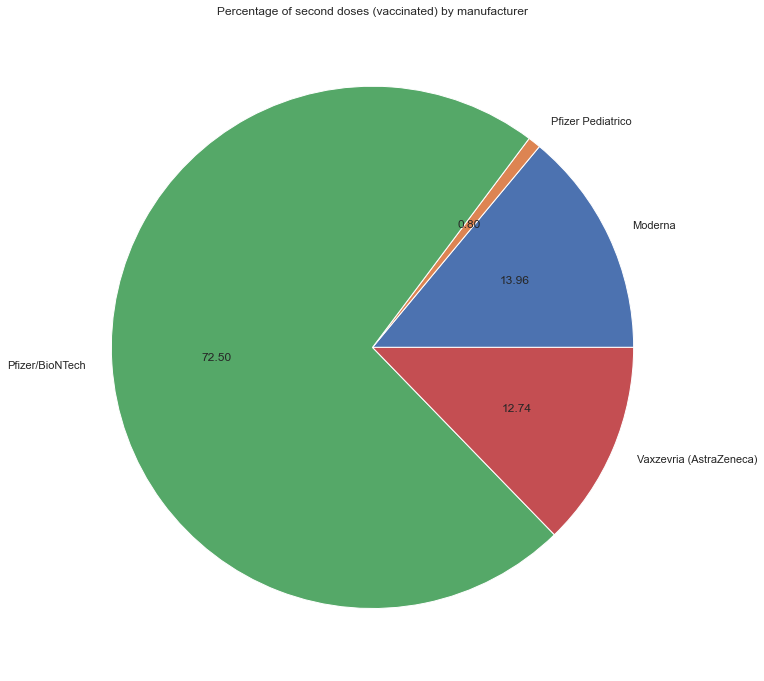

In [7]:
vaccinati.groupby("fornitore")["seconda_dose"].sum().plot.pie(autopct='%.2f',
                                                             ylabel='',
                                                             title='Percentage of second doses (vaccinated) by manufacturer')
plt.savefig('2st_dose.png')

Then we analyze, for each region, the count of vaccine by each manufacturer just to take a look at proportions between administrations. Clearly Pfizer is preferred among all regions but regarding the second most used we have almost equivalent proportions of Moderna and Vaxzevria. Another thing is that Pfizer Pediatrico is not being used (currently) by all regions. 

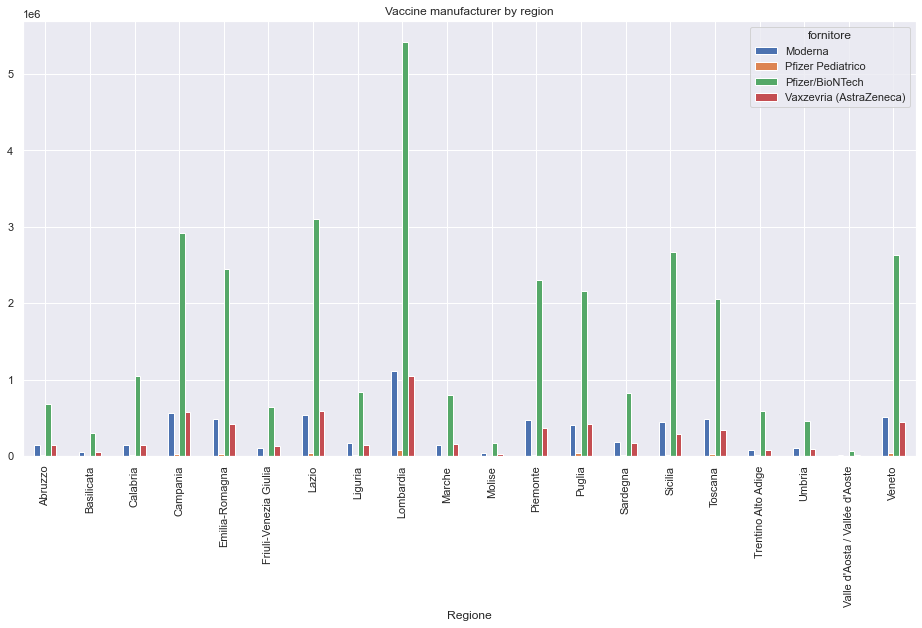

In [8]:
sns.set(rc={'figure.figsize':(16,8)})
vaccinati.groupby(["nome_area","fornitore"])["seconda_dose"].sum().unstack().plot.bar(xlabel='Regione',
                                                             title='Vaccine manufacturer by region')
plt.savefig('vaccine_x_manufacturer.png')

The same applies for this plot of vaccine manufacturer by age group. There is a growing trend in number of Pfizer doses from teenagers until 50-59. An interesting thing is that Vaxzevria was used mainly on elderly people but not over 70-79. Trivially Pfizer Pediatrico reguards only the age group of 05-11.

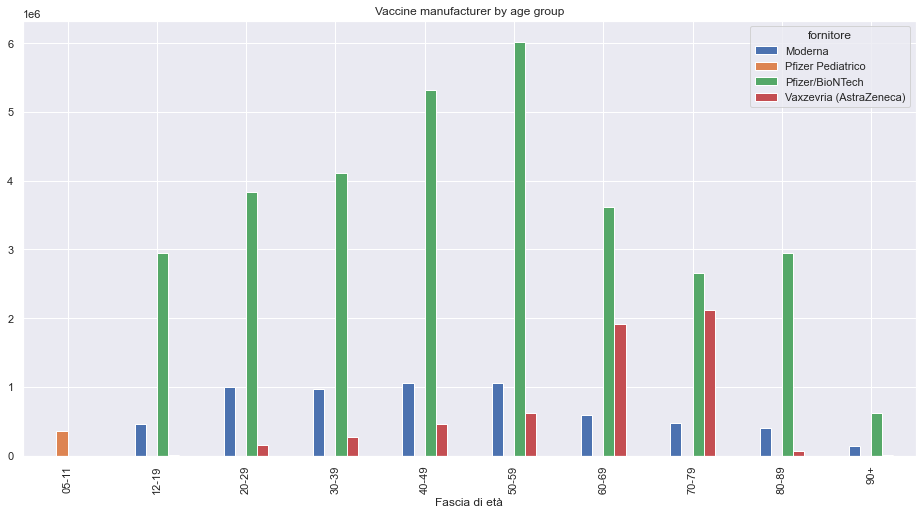

In [9]:
sns.set(rc={'figure.figsize':(16,8)})
vaccinati.groupby(["fascia_anagrafica","fornitore"])["seconda_dose"].sum().unstack().plot.bar(xlabel="Fascia di età",
                                                             title='Vaccine manufacturer by age group')
plt.savefig('vaccine_x_age.png')

For a complete view of both region and age group preferences, the following representation has been used.

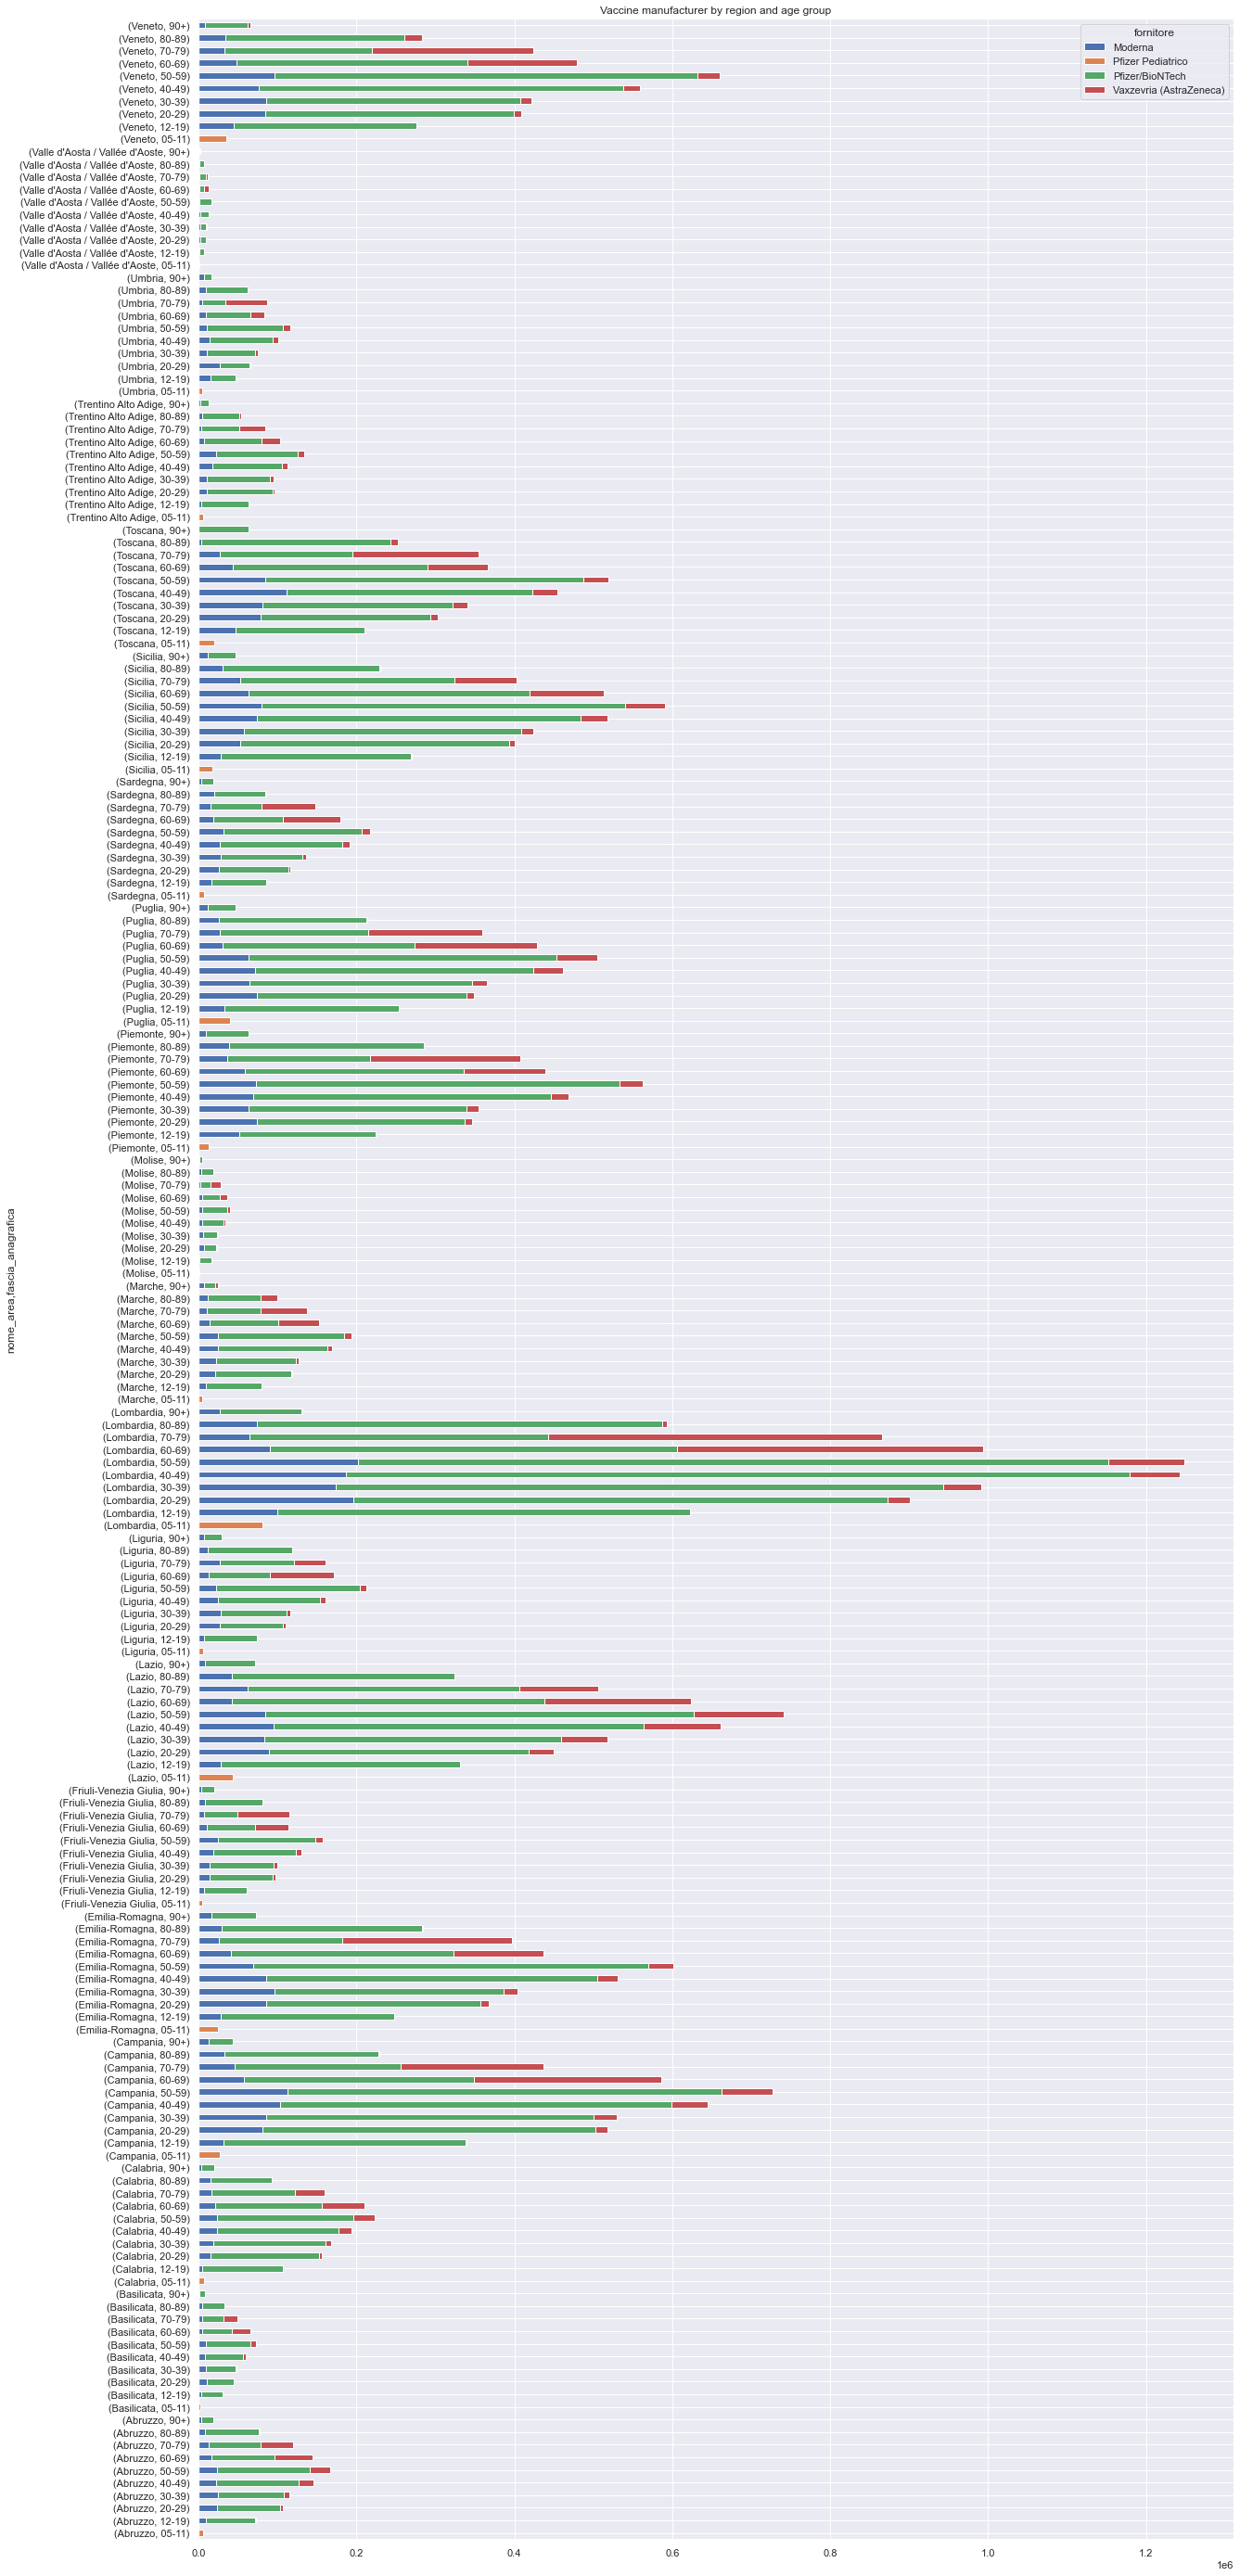

In [10]:
sns.set(rc={'figure.figsize':(20,50)})
vaccinati.groupby(["nome_area","fascia_anagrafica","fornitore"])["seconda_dose"].sum().unstack().plot(kind='barh', 
                                                                                                      stacked=True,
                                                                                                     ylabel="Regione, Fascia di età",
                                                             title='Vaccine manufacturer by region and age group')
plt.savefig('vaccine_x_region_and_age.png')

<AxesSubplot:ylabel='seconda_dose'>

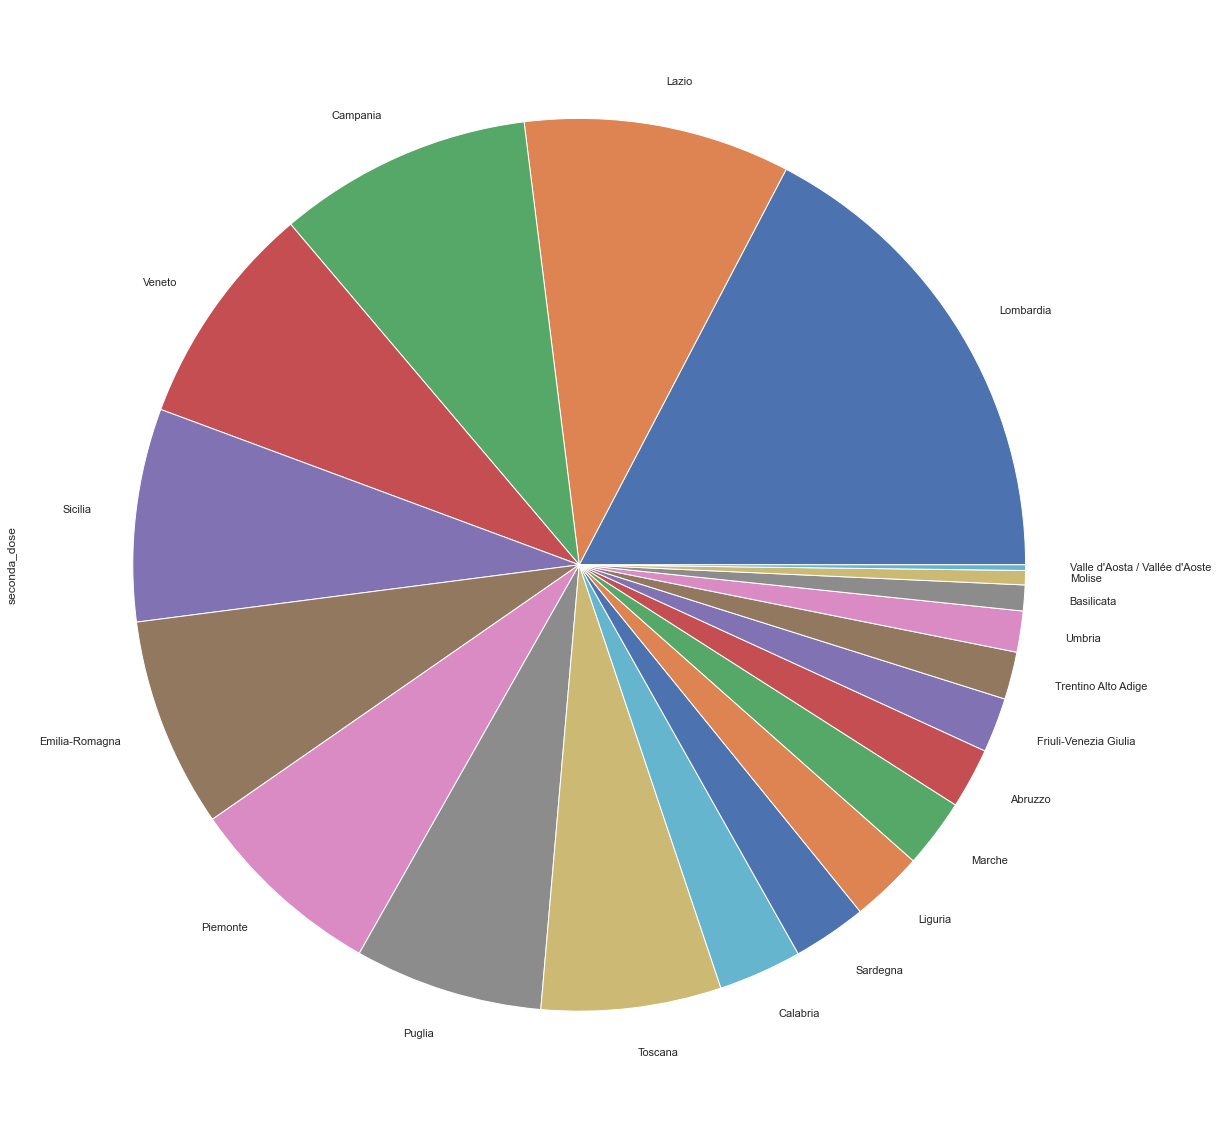

In [11]:
totPopolazioneItaliana = 59257566
totUnder12 = 7000000
totOver12 = totPopolazioneItaliana - totUnder12

vaccinati.groupby(['nome_area'])['seconda_dose'].apply(lambda x: (sum(x)/totOver12)*100).sort_values(ascending=False).plot.pie()

In [12]:
def regTotalVaccines(region, df=vaccinati):
    if isinstance(region, int) is True:
        val = df.loc[df['codice_regione_ISTAT'] == region]['seconda_dose'].sum()
        reg = df.loc[df['codice_regione_ISTAT'] == region]['nome_area'].iloc[0]
    else:
        val = df.loc[df['nome_area'] == region]['seconda_dose'].sum()
        reg = region
    #print(f"La regione {reg} ha un totale di {val} vaccinati")
    return val

In [13]:
dictFactors = {
        1: {'mono_Family': 6.8, 
                'six_more_Family': 0.8, 
                'low_Educ': 1.3,
                'ass_Unease': 3.2,
                'house_Crow': 1.1,
                'u30_Unemployed': 8.9,
                'eco_Unease': 1.4,
        'tot_Dosi': regTotalVaccines(1), 
                'residenti': 4274945,
        'PIL' : 126374.6},
        2: {'mono_Family': 7.2, 
                'six_more_Family': 0.7, 
                'low_Educ': 1.0,
                'ass_Unease': 2.8,
                'house_Crow': 1.2,
                'u30_Unemployed': 8.3,
                'eco_Unease': 1.0,
        'tot_Dosi': regTotalVaccines(2), 
                'residenti': 124089,
        'PIL' : 4522.4},
        3: {'mono_Family': 6.3, 
                'six_more_Family': 1.1, 
                'low_Educ': 1.4,
                'ass_Unease': 2.7,
                'house_Crow': 1.2,
                'u30_Unemployed': 8.1,
                'eco_Unease': 1.2,
        'tot_Dosi': regTotalVaccines(3), 
                'residenti': 9981554,
        'PIL' : 367167.2},
        4: {'mono_Family': 7.1, 
                'six_more_Family': 1.8, 
                'low_Educ': 0.8,
                'ass_Unease': 2.6,
                'house_Crow': 1.1,
                'u30_Unemployed': 6.7,
                'eco_Unease': 0.9,
        'tot_Dosi': regTotalVaccines(4), 
                'residenti': 1077078,
        'PIL' : 43821.9},
        5: {'mono_Family': 6.0, 
                'six_more_Family': 1.5, 
                'low_Educ': 1.1,
                'ass_Unease': 2.8,
                'house_Crow': 0.7,
                'u30_Unemployed': 7.4,
                'eco_Unease': 1.1,
        'tot_Dosi': regTotalVaccines(5), 
                'residenti': 4869830,
        'PIL' : 152340.6},
        6: {'mono_Family': 6.5, 
                'six_more_Family': 1.0, 
                'low_Educ': 0.7,
                'ass_Unease': 3.0,
                'house_Crow': 0.6,
                'u30_Unemployed': 7.5,
                'eco_Unease': 1.0,
        'tot_Dosi': regTotalVaccines(6), 
                'residenti': 1201510,
        'PIL' : 36814.3},
        7: {'mono_Family': 7.7, 
                'six_more_Family': 0.7, 
                'low_Educ': 1.3,
                'ass_Unease': 3.7,
                'house_Crow': 1.2,
                'u30_Unemployed': 9.2,
                'eco_Unease': 1.4,
        'tot_Dosi': regTotalVaccines(7), 
                'residenti': 1518495,
        'PIL' : 46194.7},
        8: {'mono_Family': 6.8, 
                'six_more_Family': 1.3, 
                'low_Educ': 1.4,
                'ass_Unease': 3.5,
                'house_Crow': 1.1,
                'u30_Unemployed': 8.3,
                'eco_Unease': 1.1,
        'tot_Dosi': regTotalVaccines(8), 
                'residenti': 4438937,
        'PIL' : 149633.0},
        9: {'mono_Family': 7.0, 
                'six_more_Family': 1.4, 
                'low_Educ': 1.2,
                'ass_Unease': 3.7,
                'house_Crow': 1.2,
                'u30_Unemployed': 9.2,
                'eco_Unease': 1.4,
        'tot_Dosi': regTotalVaccines(9), 
                'residenti': 3692865,
        'PIL' : 111605.6},
        10: {'mono_Family': 6.7, 
                'six_more_Family': 1.8, 
                'low_Educ': 1.1,
                'ass_Unease': 3.7,
                'house_Crow': 0.7,
                'u30_Unemployed': 8.9,
                'eco_Unease': 1.4,
            'tot_Dosi': regTotalVaccines(10), 
                'residenti': 865452,
        'PIL' : 21340.0},
        11: {'mono_Family': 6.5, 
                'six_more_Family': 1.8, 
                'low_Educ': 1.1,
                'ass_Unease': 3.9,
                'house_Crow': 1.0,
                'u30_Unemployed': 8.1,
                'eco_Unease': 1.3,
            'tot_Dosi': regTotalVaccines(11), 
                'residenti': 1498236,
        'PIL' : 39412.4},
        12: {'mono_Family': 9.1,
                'six_more_Family': 1.2, 
                'low_Educ': 1.0,
                'ass_Unease': 2.6,
                'house_Crow': 1.6,
                'u30_Unemployed': 11.9,
                'eco_Unease': 2.5,
            'tot_Dosi': regTotalVaccines(12), 
                'residenti': 5730399,
        'PIL' : 186306.9},
        13: {'mono_Family': 6.8, 
                'six_more_Family': 1.6, 
                'low_Educ': 1.2,
                'ass_Unease': 3.6,
                'house_Crow': 0.9,
                'u30_Unemployed': 10.3,
                'eco_Unease': 2.0,
            'tot_Dosi': regTotalVaccines(13), 
                'residenti': 1281012,
        'PIL' : 30662.3},
        14: {'mono_Family': 6.8, 
                'six_more_Family': 1.2, 
                'low_Educ': 1.3,
                'ass_Unease': 3.8,
                'house_Crow': 1.0,
                'u30_Unemployed': 11.5,
                'eco_Unease': 2.5,
            'tot_Dosi': regTotalVaccines(14), 
                'residenti': 294294,
        'PIL' : 6008.3},
        15: {'mono_Family': 8.0, 
                'six_more_Family': 2.8, 
                'low_Educ': 2.9,
                'ass_Unease': 2.2,
                'house_Crow': 3.5,
                'u30_Unemployed': 20.4,
                'eco_Unease': 7.6,
            'tot_Dosi': regTotalVaccines(15), 
                'residenti': 5624260,
        'PIL' : 102702.3},
        16: {'mono_Family': 6.1, 
                'six_more_Family': 1.5, 
                'low_Educ': 2.5,
                'ass_Unease': 3.1,
                'house_Crow': 1.6,
                'u30_Unemployed': 15.6,
                'eco_Unease': 4.3,
            'tot_Dosi': regTotalVaccines(16), 
                'residenti': 3933777,
        'PIL' : 70433.2},
        17: {'mono_Family': 5.5, 
                'six_more_Family': 1.1, 
                'low_Educ': 1.6,
                'ass_Unease': 3.6,
                'house_Crow': 1.4,
                'u30_Unemployed': 12.0,
                'eco_Unease': 3.1,
            'tot_Dosi': regTotalVaccines(17), 
                'residenti': 545130,
        'PIL' : 11480.3},
        18: {'mono_Family': 6.5, 
                'six_more_Family': 1.6, 
                'low_Educ': 3.0,
                'ass_Unease': 3.0,
                'house_Crow': 1.5,
                'u30_Unemployed': 17.6,
                'eco_Unease': 5.1,
            'tot_Dosi': regTotalVaccines(18), 
                'residenti': 1860601,
        'PIL' : 30759.1},
        19: {'mono_Family': 6.4, 
                'six_more_Family': 1.5, 
                'low_Educ': 3.1,
                'ass_Unease': 3.1,
                'house_Crow': 2.1,
                'u30_Unemployed': 19.4,
                'eco_Unease': 5.9,
                'tot_Dosi': regTotalVaccines(19), 
                'residenti': 4833705,
        'PIL' : 83065.0},
        20: {'mono_Family': 6.8, 
                'six_more_Family': 1.2, 
                'low_Educ': 1.5,
                'ass_Unease': 2.6,
                'house_Crow': 0.9,
                'u30_Unemployed': 12.2,
                'eco_Unease': 3.3,
                'tot_Dosi': regTotalVaccines(20), 
                'residenti': 1590044,
        'PIL' : 32121.0}}


dictFactorsDF = pd.DataFrame.from_dict(dictFactors,orient='index')
finalDF = pd.merge(dictFactorsDF, vaccinati, left_index=True, right_on='codice_regione_ISTAT')
finalDF['coverage'] = finalDF.apply(lambda x: (x.tot_Dosi/x.residenti), axis=1)
finalDF = finalDF[['data_somministrazione', 'seconda_dose', 'tot_Dosi', 'residenti', 'coverage', 'fascia_anagrafica', 'fornitore', 'codice_regione_ISTAT','nome_area','PIL','mono_Family','six_more_Family','low_Educ','ass_Unease','house_Crow','u30_Unemployed','eco_Unease']]
finalDF = finalDF.reset_index(drop=True)
finalDF.groupby(['nome_area']).last()

,data_somministrazione,seconda_dose,tot_Dosi,residenti,coverage,fascia_anagrafica,fornitore,codice_regione_ISTAT,PIL,mono_Family,six_more_Family,low_Educ,ass_Unease,house_Crow,u30_Unemployed,eco_Unease
nome_area,,,,,,,,,,,,,,,,
Abruzzo,2022-01-26,3,972151,1281012,0.76,90+,Pfizer/BioNTech,13,30662.30,6.80,1.60,1.20,3.60,0.90,10.30,2.00
Basilicata,2022-01-26,1,413259,545130,0.76,80-89,Pfizer/BioNTech,17,11480.30,5.50,1.10,1.60,3.60,1.40,12.00,3.10
Calabria,2022-01-26,4,1336744,1860601,0.72,90+,Pfizer/BioNTech,18,30759.10,6.50,1.60,3.00,3.00,1.50,17.60,5.10
Campania,2022-01-26,13,4080697,5624260,0.73,90+,Pfizer/BioNTech,15,102702.30,8.00,2.80,2.90,2.20,3.50,20.40,7.60
Emilia-Romagna,2022-01-26,2,3366477,4438937,0.76,90+,Pfizer/BioNTech,8,149633.00,6.80,1.30,1.40,3.50,1.10,8.30,1.10
Friuli-Venezia Giulia,2022-01-26,2,878644,1201510,0.73,90+,Pfizer/BioNTech,6,36814.30,6.50,1.00,0.70,3.00,0.60,7.50,1.00
Lazio,2022-01-26,2,4270582,5730399,0.75,90+,Pfizer/BioNTech,12,186306.90,9.10,1.20,1.00,2.60,1.60,11.90,2.50
Liguria,2022-01-26,4,1160681,1518495,0.76,90+,Pfizer/BioNTech,7,46194.70,7.70,0.70,1.30,3.70,1.20,9.20,1.40
Lombardia,2022-01-26,13,7671195,9981554,0.77,90+,Pfizer/BioNTech,3,367167.20,6.30,1.10,1.40,2.70,1.20,8.10,1.20


In [14]:
statsDF = finalDF.drop(['seconda_dose', 'tot_Dosi','codice_regione_ISTAT'], axis=1)
selectedDF = statsDF.describe().iloc[1::]
# alto coverage -> basso u30_Unemployed, basso low_Educ, basso six_more_Family (et al)
# basso coverage -> alto u30_Unemployed, alto low_Educ, alto six_more_Family (et al)

dfi.export(selectedDF, 'dataframe.png')

In [15]:
finalDF['target']=pd.cut(x=finalDF['coverage'], bins=[0,0.740344,0.800], labels = [0,1])
finalDF['target'] = pd.to_numeric(finalDF['target'])
finalDF.groupby(['nome_area']).last()
finalDF.dtypes

data_somministrazione     object
seconda_dose               int64
tot_Dosi                   int64
residenti                  int64
coverage                 float64
fascia_anagrafica         object
fornitore                 object
codice_regione_ISTAT       int64
nome_area                 object
PIL                      float64
mono_Family              float64
six_more_Family          float64
low_Educ                 float64
ass_Unease               float64
house_Crow               float64
u30_Unemployed           float64
eco_Unease               float64
target                     int64
dtype: object

In [16]:
data=finalDF[['tot_Dosi','fornitore','PIL','mono_Family','residenti','house_Crow','six_more_Family','low_Educ','ass_Unease','u30_Unemployed','eco_Unease','coverage','target']]

In [17]:
model=smf.ols('coverage~PIL+mono_Family+six_more_Family+low_Educ+house_Crow+ass_Unease+u30_Unemployed+eco_Unease',data=data)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               coverage   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                 2.574e+04
Date:                Thu, 27 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:56:22   Log-Likelihood:             3.8634e+05
No. Observations:              135407   AIC:                        -7.727e+05
Df Residuals:                  135398   BIC:                        -7.726e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6486      0.001    9

In [18]:
model=smf.logit('target~PIL+mono_Family+house_Crow+six_more_Family+low_Educ+ass_Unease+u30_Unemployed+eco_Unease',data=data)
result = model.fit()
print(result.summary())
 
#feature_importances=pd.DataFrame(result.conf_int()[1]).rename(columns={1:'Coefficients'}).eval("absolute_coefficients=abs(Coefficients)")
#feature_importances.sort_values('absolute_coefficients',ascending=False).drop('Intercept')[['absolute_coefficients']]
coefs = result.params.values
exps = np.exp(coefs)
[round(num, 3) for num in exps]

Optimization terminated successfully.
         Current function value: 0.384036
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                 target   No. Observations:               135407
Model:                          Logit   Df Residuals:                   135398
Method:                           MLE   Df Model:                            8
Date:                Thu, 27 Jan 2022   Pseudo R-squ.:                  0.4339
Time:                        16:56:23   Log-Likelihood:                -52001.
converged:                       True   LL-Null:                       -91855.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -25.4523      0.286    -88.849      0.000     -26.014     -24.891
PIL          

[0.0, 1.0, 1.847, 0.0, 0.048, 0.002, 7889.832, 1.136, 451.248]

In [19]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
dFrame=finalDF[['PIL','mono_Family','house_Crow','six_more_Family','low_Educ','ass_Unease','u30_Unemployed','eco_Unease','coverage']]
#Split our DataFrame into X (input) and y (output)
y = dFrame['coverage']
X = dFrame.drop('coverage', axis = 1)

#Create an empty dictionary that will be used to store our results
function_dict = {'predictor': [], 'r-squared':[]}
#Iterate through every column in X
for col in X.columns:
    #Create a dataframe called selected_X with only the 1 column
    selected_X = X[[col]]
    #Fit a model for our target and our selected column 
    model = sm.OLS(y, sm.add_constant(selected_X)).fit()
    #Predict what our target would be for our model
    y_preds = model.predict(sm.add_constant(selected_X))
    #Add the column name to our dictionary
    function_dict['predictor'].append(col)
    #Calculate the r-squared value between the target and predicted target
    r2 = np.corrcoef(y, y_preds)[0, 1]**2
    #Add the r-squared value to our dictionary
    function_dict['r-squared'].append(r2)
    
#Once it's iterated through every column, turn our dictionary into a DataFrame and sort it
function_df = pd.DataFrame(function_dict).sort_values(by=['r-squared'], ascending = False)
#Display only the top 5 predictors
display(function_df.head())

,predictor,r-squared
5,ass_Unease,0.28
3,six_more_Family,0.11
7,eco_Unease,0.10
2,house_Crow,0.09
6,u30_Unemployed,0.07


In [20]:
def next_possible_feature (X_npf, y_npf, current_features, ignore_features=[]):
    '''
    This function will loop through each column that isn't in your feature model and 
    calculate the r-squared value if it were the next feature added to your model. 
    It will display a dataframe with a sorted r-squared value.
    X_npf = X dataframe
    y_npf = y dataframe
    current_features = list of features that are already in your model
    ignore_features = list of unused features we want to skip over
    '''   
    #Create an empty dictionary that will be used to store our results
    function_dict = {'predictor': [], 'r-squared':[]}
    #Iterate through every column in X
    for col in X_npf.columns:
        #But only create a model if the feature isn't already selected or ignored
        if col not in (current_features+ignore_features):
            #Create a dataframe called function_X with our current features + 1
            selected_X = X_npf[current_features + [col]]
            #Fit a model for our target and our selected columns 
            model = sm.OLS(y_npf, sm.add_constant(selected_X)).fit()
            #Predict what  our target would be for our selected columns
            y_preds = model.predict(sm.add_constant(selected_X))
            #Add the column name to our dictionary
            function_dict['predictor'].append(col)
            #Calculate the r-squared value between the target and predicted target
            r2 = np.corrcoef(y_npf, y_preds)[0, 1]**2
            #Add the r-squared value to our dictionary
            function_dict['r-squared'].append(r2)
    #Once it's iterated through every column, turn our dict into a sorted DataFrame
    function_df = pd.DataFrame(function_dict).sort_values(by=['r-squared'],\
                                                          ascending = False)
    #Display only the top 5 predictors
    display(function_df.head())
    
#Start with the first predictor, and see all possibilities for our second.
selected_features = ['ass_Unease']
features_to_ignore = []
#Since our function's ignore_features list is already empty, we don't need to 
#include our features_to_ignore list.
next_possible_feature (X_npf=X, y_npf=y, current_features=selected_features)

,predictor,r-squared
0,PIL,0.48
3,six_more_Family,0.31
4,low_Educ,0.31
6,eco_Unease,0.30
5,u30_Unemployed,0.30


In [21]:
#Define an empty dataframe to capture the VIF scores
vif_2 = pd.DataFrame()
#Create a Dataframe with only our selected features 
X_2 = X[['ass_Unease', 'PIL']]
#Label the scores with their related columns
vif_2["features"] = X_2.columns
#For each column,run a variance_inflaction_factor against all other columns
# to get a VIF Factor score
vif_2["VIF"] = [variance_inflation_factor(X_2.values, i) \
                for i in range(len(X_2.columns))]
vif_2

,features,VIF
0,ass_Unease,1.83
1,PIL,1.83


In [22]:
#Select our first 2 features.
selected_features = ['ass_Unease', 'PIL']
#ignore mulitcollinear features
next_possible_feature (X_npf=X, y_npf=y, current_features=selected_features)

,predictor,r-squared
3,low_Educ,0.50
0,mono_Family,0.49
2,six_more_Family,0.49
1,house_Crow,0.49
4,u30_Unemployed,0.49


In [23]:
#Define an empty dataframe to capture the VIF scores
vif_3 = pd.DataFrame()
#Create a Dataframe with only our selected features 
X_3 = X[['ass_Unease', 'PIL', 'low_Educ']]
#Label the scores with their related columns
vif_3["features"] = X_3.columns
#For each column,run a variance_inflaction_factor against all other columns
# to get a VIF Factor score
vif_3["VIF"] = [variance_inflation_factor(X_3.values, i) \
                for i in range(len(X_3.columns))]
vif_3

,features,VIF
0,ass_Unease,4.82
1,PIL,1.86
2,low_Educ,4.43


In [24]:
#Create a Dataframe with only our selected features 
X_3 = X[['ass_Unease', 'PIL', 'low_Educ']]
#Label the scores with their related columns
vif_3["features"] = X_3.columns
#For each column,run a variance_inflaction_factor against all other columns
# to get a VIF Factor score
vif_3["VIF"] = [variance_inflation_factor(X_3.values, i) \
                for i in range(len(X_3.columns))]
vif_3

,features,VIF
0,ass_Unease,4.82
1,PIL,1.86
2,low_Educ,4.43


In [25]:
#Select our first 2 features.
selected_features = ['ass_Unease', 'PIL', 'low_Educ']
#ignore mulitcollinear features
next_possible_feature (X_npf=X, y_npf=y, current_features=selected_features)

,predictor,r-squared
4,eco_Unease,0.56
3,u30_Unemployed,0.56
0,mono_Family,0.50
1,house_Crow,0.50
2,six_more_Family,0.50


In [26]:
#Define an empty dataframe to capture the VIF scores
vif_4 = pd.DataFrame()
#Create a Dataframe with only our selected features 
X_4 = X[['ass_Unease', 'PIL', 'low_Educ','eco_Unease']]
#Label the scores with their related columns
vif_4["features"] = X_4.columns
#For each column,run a variance_inflaction_factor against all other columns
# to get a VIF Factor score
vif_4["VIF"] = [variance_inflation_factor(X_4.values, i) \
                for i in range(len(X_4.columns))]
vif_4

,features,VIF
0,ass_Unease,7.23
1,PIL,2.06
2,low_Educ,42.29
3,eco_Unease,22.16


In [27]:
#Define an empty dataframe to capture the VIF scores
vif_4 = pd.DataFrame()
#Create a Dataframe with only our selected features 
X_4 = X[['ass_Unease', 'PIL', 'low_Educ','u30_Unemployed']]
#Label the scores with their related columns
vif_4["features"] = X_4.columns
#For each column,run a variance_inflaction_factor against all other columns
# to get a VIF Factor score
vif_4["VIF"] = [variance_inflation_factor(X_4.values, i) \
                for i in range(len(X_4.columns))]
vif_4

,features,VIF
0,ass_Unease,7.23
1,PIL,1.88
2,low_Educ,42.72
3,u30_Unemployed,57.19


In [28]:
#Define an empty dataframe to capture the VIF scores
vif_4 = pd.DataFrame()
#Create a Dataframe with only our selected features 
X_4 = X[['ass_Unease', 'PIL', 'low_Educ','six_more_Family']]
#Label the scores with their related columns
vif_4["features"] = X_4.columns
#For each column,run a variance_inflaction_factor against all other columns
# to get a VIF Factor score
vif_4["VIF"] = [variance_inflation_factor(X_4.values, i) \
                for i in range(len(X_4.columns))]
vif_4

,features,VIF
0,ass_Unease,7.49
1,PIL,1.87
2,low_Educ,6.32
3,six_more_Family,9.87


In [29]:
#Define an empty dataframe to capture the VIF scores
vif_4 = pd.DataFrame()
#Create a Dataframe with only our selected features 
X_4 = X[['ass_Unease', 'PIL', 'low_Educ','mono_Family']]
#Label the scores with their related columns
vif_4["features"] = X_4.columns
#For each column,run a variance_inflaction_factor against all other columns
# to get a VIF Factor score
vif_4["VIF"] = [variance_inflation_factor(X_4.values, i) \
                for i in range(len(X_4.columns))]
vif_4

,features,VIF
0,ass_Unease,22.44
1,PIL,2.19
2,low_Educ,4.89
3,mono_Family,28.13


In [30]:
#Define an empty dataframe to capture the VIF scores
vif_4 = pd.DataFrame()
#Create a Dataframe with only our selected features 
X_4 = X[['ass_Unease', 'PIL', 'low_Educ','house_Crow']]
#Label the scores with their related columns
vif_4["features"] = X_4.columns
#For each column,run a variance_inflaction_factor against all other columns
# to get a VIF Factor score
vif_4["VIF"] = [variance_inflation_factor(X_4.values, i) \
                for i in range(len(X_4.columns))]
vif_4

,features,VIF
0,ass_Unease,4.85
1,PIL,2.00
2,low_Educ,12.35
3,house_Crow,11.38


In [31]:
final_features = ['ass_Unease', 'PIL', 'low_Educ']
final_X = X[final_features]
final_model = sm.OLS(y, sm.add_constant(final_X)).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               coverage   R-squared:                       0.496
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                 4.434e+04
Date:                Thu, 27 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:56:26   Log-Likelihood:             3.7006e+05
No. Observations:              135407   AIC:                        -7.401e+05
Df Residuals:                  135403   BIC:                        -7.401e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6440      0.000   1802.431      0.000       0.643       0.645
ass_Unease     0.0303   9.61e-05    315.727      0.000       0.030       0.031
PIL         1.204e-07   5.36e-10    224.807      0.000    1.19e-07    1.21e-07
low_Educ      -0.0032      6e-05    -53.701      0.000      -0.003      -0.003
==============================================================================
Omnibus:                     2511.746   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1655.887
Skew:                          -0.145   Prob(JB):                         0.00
Kurtosis:                       2.542   Cond. No.                     1.07e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.07e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
final_features = ['PIL','mono_Family','house_Crow','six_more_Family','low_Educ','ass_Unease','u30_Unemployed','eco_Unease']
final_X = X[final_features]
final_model = sm.OLS(y, sm.add_constant(final_X)).fit()
final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               coverage   R-squared:                       0.603
Model:                            OLS   Adj. R-squared:                  0.603
Method:                 Least Squares   F-statistic:                 2.574e+04
Date:                Thu, 27 Jan 2022   Prob (F-statistic):               0.00
Time:                        16:56:26   Log-Likelihood:             3.8634e+05
No. Observations:              135407   AIC:                        -7.727e+05
Df Residuals:                  135398   BIC:                        -7.726e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.6486      0.001    986.732      0.000       0.647       0.650
PIL              1.811e-07    6.1e-10    296.954      0.000     1.8e-07    1.82e-07
mono_Family         0.0019      0.000     18.866      0.000       0.002       0.002
house_Crow         -0.0136      0.000    -69.722      0.000      -0.014      -0.013
six_more_Family    -0.0104      0.000    -79.509      0.000      -0.011      -0.010
low_Educ           -0.0249      0.000   -105.920      0.000      -0.025      -0.024
ass_Unease          0.0416      0.000    329.511      0.000       0.041       0.042
u30_Unemployed     -0.0054      0.000    -43.754      0.000      -0.006      -0.005
eco_Unease          0.0268      0.000     98.798      0.000       0.026       0.027
==============================================================================
Omnibus:                     2358.810   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4848.079
Skew:                          -0.023   Prob(JB):                         0.00
Kurtosis:                       3.926   Cond. No.                     2.18e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""